In [1]:
# License: BSD
# Author: Sasank Chilamkurthy
# Code from PyTorch website

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
%mkdir datasets

## models
[resnet, alexnet, vgg, squeezenet, densenet, inception]

## Train Dog vs Cat

In [13]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './datasets/dogsVcats'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
print(class_names)

['cat', 'dog']


In [15]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

UnidentifiedImageError: Caught UnidentifiedImageError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/pan/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/pan/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/pan/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 58, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/pan/anaconda3/lib/python3.8/site-packages/torchvision/datasets/folder.py", line 229, in __getitem__
    sample = self.loader(path)
  File "/home/pan/anaconda3/lib/python3.8/site-packages/torchvision/datasets/folder.py", line 268, in default_loader
    return pil_loader(path)
  File "/home/pan/anaconda3/lib/python3.8/site-packages/torchvision/datasets/folder.py", line 247, in pil_loader
    img = Image.open(f)
  File "/home/pan/anaconda3/lib/python3.8/site-packages/PIL/Image.py", line 2967, in open
    raise UnidentifiedImageError(
PIL.UnidentifiedImageError: cannot identify image file <_io.BufferedReader name='./datasets/dogsVcats/train/cat/._cat-66_jpg.rf.08fab47e6c8c059844ee055a0a54ac8b.jpg'>


In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Fine-tune CovNet

#### Full train

In [11]:
model_ft = models.resnet18(weights='DEFAULT')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/pan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


UnidentifiedImageError: Caught UnidentifiedImageError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/home/pan/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/pan/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/pan/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 58, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/pan/anaconda3/lib/python3.8/site-packages/torchvision/datasets/folder.py", line 229, in __getitem__
    sample = self.loader(path)
  File "/home/pan/anaconda3/lib/python3.8/site-packages/torchvision/datasets/folder.py", line 268, in default_loader
    return pil_loader(path)
  File "/home/pan/anaconda3/lib/python3.8/site-packages/torchvision/datasets/folder.py", line 247, in pil_loader
    img = Image.open(f)
  File "/home/pan/anaconda3/lib/python3.8/site-packages/PIL/Image.py", line 2967, in open
    raise UnidentifiedImageError(
PIL.UnidentifiedImageError: cannot identify image file <_io.BufferedReader name='datasets/dogsVcats/train/cat/._cat-274_jpg.rf.e6c87396901a18831b286089b5499497.jpg'>


In [ ]:
visualize_model(model_ft)

In [ ]:
torch.save(model_ft, '../models/model_conv_1.pt')

#### ConvNet as fixed feature extractor

In [14]:
model_conv = models.resnet18(weights='DEFAULT')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [15]:
model_conv = train_model(model_conv, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7975 Acc: 0.4923


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


valid Loss: 0.7506 Acc: 0.5375

Epoch 1/24
----------
train Loss: 0.7987 Acc: 0.4935
valid Loss: 0.7455 Acc: 0.5292

Epoch 2/24
----------
train Loss: 0.7969 Acc: 0.4937
valid Loss: 0.7401 Acc: 0.5479

Epoch 3/24
----------
train Loss: 0.7985 Acc: 0.4937
valid Loss: 0.7665 Acc: 0.5312

Epoch 4/24
----------
train Loss: 0.7947 Acc: 0.4929
valid Loss: 0.7354 Acc: 0.5354

Epoch 5/24
----------
train Loss: 0.7971 Acc: 0.4929
valid Loss: 0.7416 Acc: 0.5354

Epoch 6/24
----------
train Loss: 0.7971 Acc: 0.4954
valid Loss: 0.7289 Acc: 0.5333

Epoch 7/24
----------
train Loss: 0.8049 Acc: 0.4917
valid Loss: 0.7280 Acc: 0.5375

Epoch 8/24
----------
train Loss: 0.8012 Acc: 0.4944
valid Loss: 0.7252 Acc: 0.5354

Epoch 9/24
----------
train Loss: 0.7995 Acc: 0.4937
valid Loss: 0.7126 Acc: 0.5375

Epoch 10/24
----------
train Loss: 0.8001 Acc: 0.4911
valid Loss: 0.7567 Acc: 0.5271

Epoch 11/24
----------
train Loss: 0.7972 Acc: 0.4940
valid Loss: 0.7287 Acc: 0.5312

Epoch 12/24
----------
train Lo

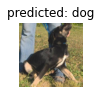

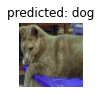

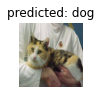

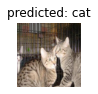

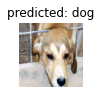

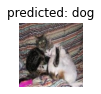

In [16]:
visualize_model(model_conv)

In [18]:
torch.save(model_ft, '../models/model_conv_2.pt')

### GhostNet

In [23]:
model_gh = torch.hub.load('huawei-noah/ghostnet', 'ghostnet_1x', pretrained=True)
model_gh.eval()

Using cache found in /Users/conan/.cache/torch/hub/huawei-noah_ghostnet_master


ModuleNotFoundError: No module named 'cupy'

In [22]:
!pip install cupy

  Using cached cupy-11.3.0.tar.gz (1.8 MB)
  Preparing metadata (setup.py) ... done
  Using cached fastrlock-0.8.1-cp39-cp39-macosx_10_15_x86_64.whl (31 kB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [59 lines of output]
      
      -------- Configuring Module: cuda --------
      xcrun: error: active developer path ("/Applications/Xcode.app/Contents/Developer") does not exist
      Use `sudo xcode-select --switch path/to/Xcode.app` to specify the Xcode that you wish to use for command line developer tools, or use `xcode-select --install` to install the standalone command line developer tools.
      See `man xcode-select` for more details.
      command '/usr/bin/gcc' failed with exit code 1
      xcrun: error: active developer path ("/Applications/Xcode.app/Contents/Developer") does not exist
      Use `sudo xcode-select --switch path/to/Xcode.app` to specify the Xcode that you wish to use for command line

In [20]:
!pip install timm

  Using cached timm-0.6.12-py3-none-any.whl (549 kB)


In [ ]:
num_ftrs = model_gh.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_gh.fc = nn.Linear(num_ftrs, 2)

model_gh = model_gh.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_gh.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_gh = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

### Semi supervised

In [24]:
model_ss = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', 'resnet18_swsl')


Using cache found in /Users/conan/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:

num_ftrs = model_ss.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ss.fc = nn.Linear(num_ftrs, 2)

model_ss = model_ss.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ss.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ss = train_model(model_ss, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.4976 Acc: 0.7550
valid Loss: 0.2496 Acc: 0.8896

Epoch 1/4
----------
train Loss: 0.3260 Acc: 0.8452
valid Loss: 0.1681 Acc: 0.9229

Epoch 2/4
----------
train Loss: 0.2794 Acc: 0.8677
valid Loss: 0.1129 Acc: 0.9437

Epoch 3/4
----------
train Loss: 0.2501 Acc: 0.8829
valid Loss: 0.0833 Acc: 0.9646

Epoch 4/4
----------


In [ ]:
model_swsl50 = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', 'resnet50_swsl')
model_swsl5032 = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', 'resnext50_32x4d_swsl')
model_swsl101324d = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', 'resnext101_32x4d_swsl')
model_swsl101328d = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', 'resnext101_32x8d_swsl')
model_swsl1013216d = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', 'resnext101_32x16d_swsl')
# ================= SEMI-SUPERVISED MODELS PRETRAINED WITH YFCC100M ==================
model_ssl18 = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', 'resnet18_ssl')
model_ssl50 = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', 'resnet50_ssl')
model_ssl50324d = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', 'resnext50_32x4d_ssl')
model_ssl101324d = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', 'resnext101_32x4d_ssl')
model_ssl101328d = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', 'resnext101_32x8d_ssl')
model_ssl1013216d = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', 'resnext101_32x16d_ssl')

Using cache found in /Users/conan/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master
/Users/conan/Desktop/image_app/env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/conan/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
4.9%

In [1]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

NameError: name 'torch' is not defined

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet169', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet201', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet161', pretrained=True)

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True)
# or
# model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet101', pretrained=True)

In [ ]:
resneXt = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resneXt')